# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds #.PHIHYD #, state_ds.DRHODR

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

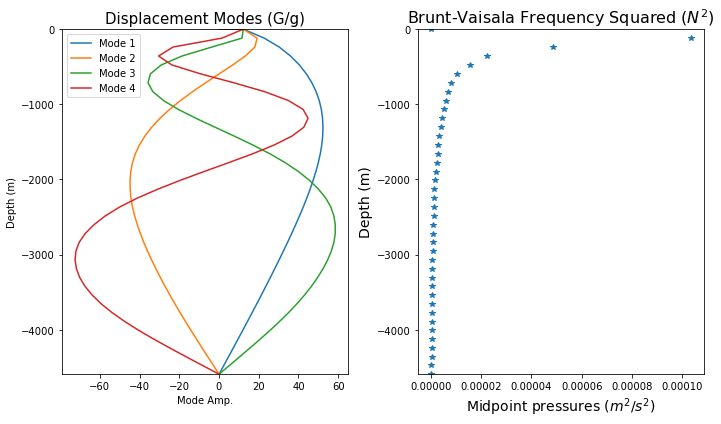

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [20]:
MODE = G.shape[-1]

In [21]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_30836/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_30836/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_30836/53837551.py:25: MatplotlibDeprec

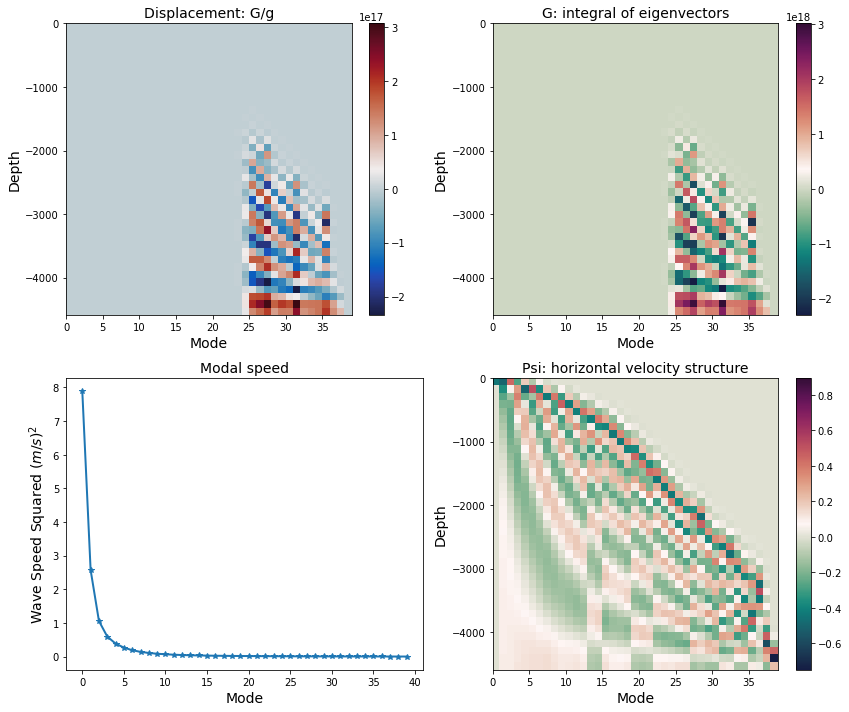

In [22]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [23]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode, here we give a wrong disperson relationship by reduce the Rossby deformation radius by 10 km

In [32]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 - 10 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber

freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size
Amp.shape, Amp

((2, 5, 3),
 array([[[0.14483034, 0.24962751, 0.65104115],
         [0.47493422, 0.54043157, 0.57510509],
         [0.0751053 , 0.41699497, 0.90778973],
         [0.72482853, 0.4697813 , 0.92959236],
         [0.16414035, 0.61039032, 0.68468442]],
 
        [[0.07778099, 0.21199496, 0.58603898],
         [0.67784895, 0.13046299, 0.78210257],
         [0.87754802, 0.1086051 , 0.54663167],
         [0.64725976, 0.94365613, 0.36419692],
         [0.26739167, 0.90792681, 0.17606765]]]))

In [33]:
X_loc = np.arange(0, 1e6, 1e4) # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e10, 1e8) # Time step : ~11days

### H Matrix and SSH

In [34]:
%%time
H_cos = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)] ) # Number of waves * Number of data
H_sin = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
SSH_XYTMN = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
for tt in range(len(T_time)):
    for xx in range(len(X_loc)):
        for yy in range(len(Y_loc)):
            for mm in range(Amp.shape[1]):
                for nn in range(len(k_n)):
                    H_cos[tt, xx, yy, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt]) 
                    H_sin[tt, xx, yy, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt])

for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_XYTMN[:, :, :, mm, nn] = Amp[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 1min 2s, sys: 256 ms, total: 1min 2s
Wall time: 1min 3s


#### Add up long the last two axis: modes, frequences

In [35]:
SSH_XYT = np.sum(SSH_XYTMN, axis = (-1, -2))

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

In [96]:
tindex= np.random.randint(low = 0, high= 99, size= 60)
yindex = np.random.randint(low = 0, high= 99, size= 60) #np.array([4, 32, 61, 86, 92, 99])
xindex = np.random.randint(low = 0, high= 99, size= 60) #np.array([15, 20, 30, 40, 55, 60]) 
y_m = SSH_XYT[tindex, xindex, yindex].data
M, N = Amp.size, y_m.size

In [97]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes*2, len(wavelength)]) # Number of data * Number of models
H_[:, :, :, 0::2] = H_cos #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')
H_[:, :, :, 1::2] = H_sin #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')

In [98]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    IIndex[iii] = nx * ny * tindex[iii] + ny * xindex[iii] + xindex[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xindex[iii], yindex[iii]]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xindex[iii] + xindex[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[tindex[iii], xindex[iii], yindex[iii], mm, nn]
            H_v[iii, JIndex + 1] = H_sin[tindex[iii], xindex[iii], yindex[iii], mm, nn]

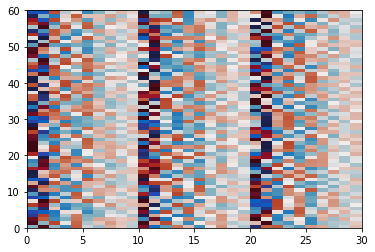

In [99]:
plt.pcolor(H_v, cmap = cmo.cm.balance)

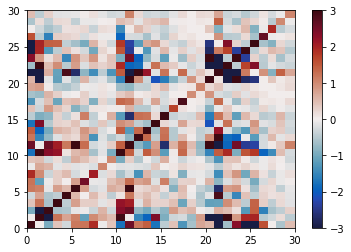

In [100]:
plt.pcolor(np.matmul(H_v.T, H_v), vmin = -3, vmax = 3, cmap = cmo.cm.balance)
plt.colorbar()

#### Weighted least square solution

In [101]:
num_samples = len(Y_loc)
noise_std = 2

In [102]:
SSH_WN = np.ma.masked_all(SSH_XYT.shape)
white_noise_x, white_noise_y = np.ma.masked_all(SSH_XYT.shape), np.ma.masked_all(SSH_XYT.shape)
for tt in range(len(T_time)):
    for yy in range(len(Y_loc)):
        white_noise_y[tt, yy] = np.random.normal(0, noise_std, size = num_samples)
        SSH_WN[tt, yy] = SSH_XYT[tt, yy] 

#### R and P Matrix

In [103]:
R_ = np.eye(N, N)

In [104]:
P_ = np.eye(M, M)

In [105]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [106]:
A = np.matmul(H_v.T, LA.inv(R_))

In [107]:
HRH = np.matmul(A, H_v)

In [108]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [109]:
eig, vec = LA.eig(HRH)
eig.real

array([4031.37375983, 3937.36152044, 2844.46775713, 2480.57399019,
       1969.69531591, 1828.76322967, 1063.95697328,  939.47637348,
        737.37829194,  656.58085102,  565.03583334,  547.06491329,
        519.51240718,  435.57307122,  354.37581383,  284.79847671,
        241.07207656,  201.06625771,  160.13846605,  144.67854115,
        117.12705123,   99.63338341,   10.61663247,    7.15827036,
         78.71714076,   74.24090416,   57.04426682,   48.80308324,
         34.33822867,   36.17279847])

#### Soution with noise

In [110]:
X_ = np.matmul(D, Y_v)

In [111]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

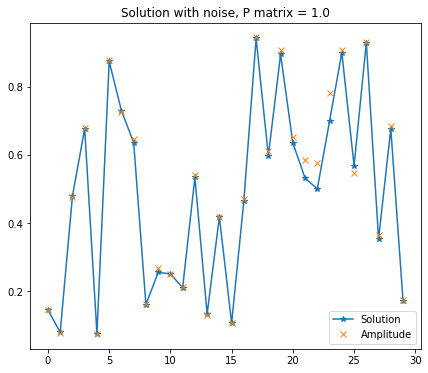

In [112]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'-*', label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'_wrong_disperson_relation.png')

In [113]:
SOL_WN, Amp.reshape([M], order = 'F')

(array([0.14557057, 0.08009333, 0.47897989, 0.67635635, 0.07595049,
        0.87375933, 0.72920249, 0.63578624, 0.16104688, 0.2554684 ,
        0.25116576, 0.21077691, 0.53347558, 0.13340266, 0.418203  ,
        0.10696112, 0.46581228, 0.94128785, 0.59715335, 0.89436449,
        0.63471145, 0.53125133, 0.50029944, 0.69872664, 0.89925117,
        0.5678742 , 0.92821425, 0.35379441, 0.67621185, 0.17187256]),
 array([0.14483034, 0.07778099, 0.47493422, 0.67784895, 0.0751053 ,
        0.87754802, 0.72482853, 0.64725976, 0.16414035, 0.26739167,
        0.24962751, 0.21199496, 0.54043157, 0.13046299, 0.41699497,
        0.1086051 , 0.4697813 , 0.94365613, 0.61039032, 0.90792681,
        0.65104115, 0.58603898, 0.57510509, 0.78210257, 0.90778973,
        0.54663167, 0.92959236, 0.36419692, 0.68468442, 0.17606765]))

In [114]:
diff = SOL_WN - Amp.reshape([M], order = 'F')

In [115]:
rms = np.sqrt(np.mean(diff**2))
rms

0.024032648259902083

#### Check whether Y == Hx

In [79]:
np.mean(np.matmul(H_v, SOL_WN) - Y_v)

-0.0006653808137520767

In [80]:
np.mean(np.matmul(H_v, SOL_WN) - Y_v)

-0.0006653808137520767

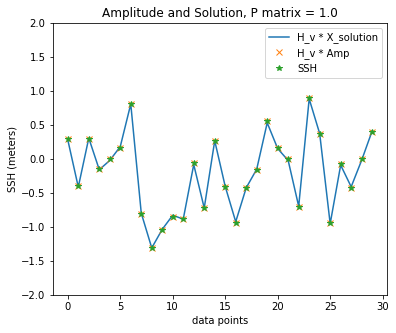

In [81]:
plt.figure(figsize = (6, 5))
plt.plot(np.matmul(H_v, SOL_WN), label = 'H_v * X_solution')
plt.plot(np.matmul(H_v, Amp.reshape([M], order = 'F')), 'x', label = 'H_v * Amp')
plt.plot(Y_v, '*', label = 'SSH')
plt.xlabel('data points')
plt.ylabel('SSH (meters)')
plt.legend(loc = 'best')
plt.ylim([-2, 2])
plt.title('Amplitude and Solution, P matrix = ' + str(P_[0, 0]) )
plt.savefig('SSH_Hv_X_solution_P'+ str(P_[0, 0])  +'.png')

Text(0.5, 1.0, 'Amplitude and Solution, P matrix = 1.0')

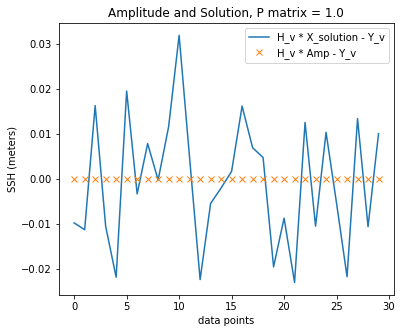

In [82]:
plt.figure(figsize = (6, 5))
plt.plot(np.matmul(H_v, SOL_WN)- Y_v, label = 'H_v * X_solution - Y_v')
plt.plot(np.matmul(H_v, Amp.reshape([M], order = 'F')) - Y_v, 'x', label = 'H_v * Amp - Y_v')
#plt.plot(Y_v, '*', label = 'SSH')
plt.xlabel('data points')
plt.ylabel('SSH (meters)')
plt.legend(loc = 'best')
#plt.ylim([-2, 2])
plt.title('Amplitude and Solution, P matrix = ' + str(P_[0, 0]) )
#plt.savefig('SSH_Hv_X_solution_P'+ str(P_[0, 0])  +'.png')

#### Batch plot and make movie

In [86]:
for tt in range(len(T_time)):
    plt.figure(figsize = (12, 9))
    plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_XYT[tt], cmap = cmo.cm.balance, vmin = -2., vmax = 2. )
    plt.xlabel('Distance(km)')
    plt.ylabel('Distance(km)')
    plt.title('Time ' + str(tt/1e6) + ' 1e6 seconds')
    plt.colorbar()
    plt.savefig('./SSH_XYT_30waves_5modes/SSH_XYT_' + str(T_time[tt]/1e6).zfill(4) + '.png')
    plt.close()

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_30836/1631298850.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_XYT[tt], cmap = cmo.cm.balance, vmin = -2., vmax = 2. )


In [87]:
def make_gif(*, pic_path, gif_path):
    '''
    pic_path: full path and name of picture input(eg.:'./adv_ml_05d/adv_ml*.png')
    gif_path: full path an name if the gif output(eg.:'./adv_ml_05d.gif')
    '''
    
    import imageio
    import glob
    
    images = []
    imagenames = glob.glob(pic_path)
    imagenames = sorted(imagenames[0::5])
    for filename in imagenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images)

In [88]:
make_gif(pic_path = './SSH_XYT_30waves_5modes/SSH_XYT_*.png', gif_path='./SSH_XYT_15waves_wrong_disperson_relation.gif')